In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import seaborn as sbn
from sklearn.preprocessing import minmax_scale

# Import Data

In [2]:
source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
data = pd.read_csv(source, sep=' ', header = None)
column_names = ['checking account', 'duration', 'credit history', 'purpose', 'credit amount'
                , 'savings account', 'present employment', 'installment rate', 'personal status', 'debtors'
                , 'present residence', 'property', 'age', 'other installment plan', 'housing' 
                , 'existing credit', 'job', 'people liable', 'telephone', 'foreign worker'
                , 'outcome']
data.columns = column_names
print('data shape:',data.shape)

data shape: (1000, 21)


In [3]:
print('good:',data[data.iloc[:,-1]==1].shape[0])
print('bad:',data[data.iloc[:,-1]==2].shape[0])

good: 700
bad: 300


# Label Encoder 

In [6]:
from sklearn.preprocessing import LabelEncoder
order_list = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19, 20]
for i in order_list:
    encode = LabelEncoder()
    encode.fit(np.sort(data.iloc[:,i].unique()))
    data.iloc[:,i] = encode.transform(data.iloc[:,i])

In [7]:
data.describe()

,checking account,duration,credit history,purpose,credit amount,savings account,present employment,installment rate,personal status,debtors,...,property,age,other installment plan,housing,existing credit,job,people liable,telephone,foreign worker,outcome
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.577000,20.903000,2.54500,3.277000,3271.258000,1.105000,2.384000,2.973000,1.68200,0.145000,...,1.358000,35.546000,1.675000,0.929000,1.407000,1.904000,1.155000,0.404000,0.037000,0.300000
std,1.257638,12.058814,1.08312,2.739302,2822.736876,1.580023,1.208306,1.118715,0.70808,0.477706,...,1.050209,11.375469,0.705601,0.531264,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,0.000000,4.000000,0.00000,0.000000,250.000000,0.000000,0.000000,1.000000,0.00000,0.000000,...,0.000000,19.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,2.00000,1.000000,1365.500000,0.000000,2.000000,2.000000,1.00000,0.000000,...,0.000000,27.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,18.000000,2.00000,3.000000,2319.500000,0.000000,2.000000,3.000000,2.00000,0.000000,...,1.000000,33.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,24.000000,4.00000,4.000000,3972.250000,2.000000,4.000000,4.000000,2.00000,0.000000,...,2.000000,42.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,1.000000
max,3.000000,72.000000,4.00000,9.000000,18424.000000,4.000000,4.000000,4.000000,3.00000,2.000000,...,3.000000,75.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,1.000000


# Train Test Split & Normalize 

In [8]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data.iloc[:,0:-1:1], data.iloc[:,-1], test_size=0.25
                              , shuffle=True, random_state=42)


In [9]:
from sklearn import svm
model = svm.SVC(kernel = 'linear', C=0.001 ,gamma=0.7, probability=True)
model.fit(train_X, train_y)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.7, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Find the best f1_score

In [10]:
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score 
def optimize(model, train_X, train_y):
    tpr_temp=[]
    fpr_temp=[]
    precision_temp=[]
    recall_temp=[]
    f1_score_temp=[]
    for threshold in [x/10 for x in range(10)]:
        pred = (model.predict_proba(train_X)[:,1] >= threshold).astype(int) #將預測機率大於threshold的分類為1
        cm = confusion_matrix(train_y, pred)
        tpr = cm[1][1]/cm.sum(axis=1)[1]
        fpr = cm[1][0]/cm.sum(axis=0)[0]
        pre = cm[1][1]/cm.sum(axis=0)[1] #precision
        re = cm[1][1]/cm.sum(axis=1)[1] #recall
        f1 = 2*(pre*re)/(pre+re)

        #將各種評估值存取成list
        tpr_temp.append(tpr)
        fpr_temp.append(fpr)
        precision_temp.append(0 if pre!=pre else round(pre,3))
        recall_temp.append(0 if re!=re else round(re,3))
        f1_score_temp.append(0 if f1!=f1 else round(f1,3)) #

    return f1_score_temp, tpr_temp, fpr_temp, precision_temp, recall_temp

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/Users/Jacklin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


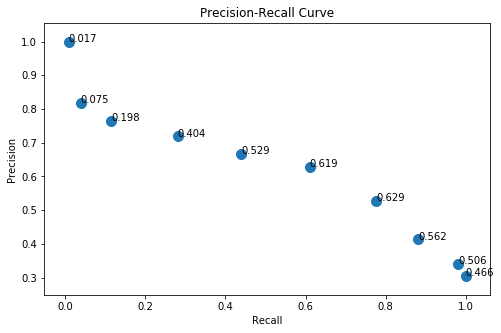

In [11]:
f1_0, tpr_0, fpr_0, precision_0, recall_0 = optimize(model, train_X, train_y )

plt.scatter(recall_0 ,precision_0, s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
# Show F1 Score on each point
for i, txt in enumerate(f1_0):
    plt.annotate(txt, (recall_0[i],precision_0[i])) 


plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score 
#prediction = model.predict(test_X.iloc[:,0:1:1])
prediction = (model.predict_proba(test_X)[:,1] > 0.3).astype(int)
print(classification_report(test_y, prediction))
print('accuracy:', accuracy_score(test_y, prediction))

             precision    recall  f1-score   support

          0       0.86      0.72      0.79       178
          1       0.51      0.72      0.60        72

avg / total       0.76      0.72      0.73       250

accuracy: 0.72


In [13]:
confusion_matrix(test_y, prediction)

array([[128,  50],
       [ 20,  52]])

# EDA & Data Preprocessin

# 0 Status of existing checking account 
A11 : ... < 0 DM 
A12 : 0 <= ... < 200 DM 
A13 : ... >= 200 DM / salary assignments for at least 1 year 
A14 : no checking account 

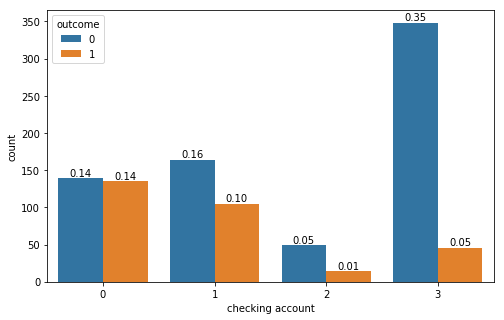

In [14]:
ax = sbn.countplot(x='checking account', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [15]:
data.iloc[:, 0] = minmax_scale(data.iloc[:, 0])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 1 Duration in month 

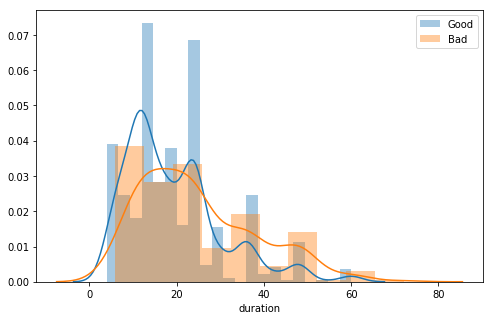

In [16]:
#ax = sbn.factorplot(x="checking account",y='duration', data=data, \
#               palette="hls", hue = "outcome" ,kind="violin" ,size=4, aspect=2, split=True)
ax = sbn.distplot(data[data.outcome==0].duration ,label='Good')
ax = sbn.distplot(data[data.outcome==1].duration ,label='Bad')
plt.legend()
plt.show()

In [17]:
data.iloc[:, 1] = minmax_scale(data.iloc[:, 1])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 2 Credit history 
A30 : no credits taken/ all credits paid back duly 
A31 : all credits at this bank paid back duly 
A32 : existing credits paid back duly till now 
A33 : delay in paying off in the past 
A34 : critical account/ other credits existing (not at this bank) 

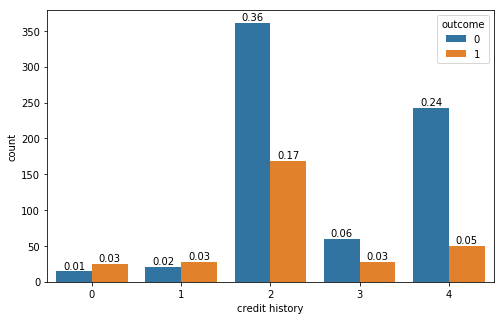

In [18]:
ax = sbn.countplot(x='credit history', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [19]:
data.iloc[:, 2] = minmax_scale(data.iloc[:, 2])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 3 Purpose 
A40 : car (new) 
A41 : car (used) 
A42 : furniture/equipment 
A43 : radio/television 
A44 : domestic appliances 
A45 : repairs 
A46 : education 
A47 : (vacation - does not exist?) 
A48 : retraining 
A49 : business 
A410 : others 

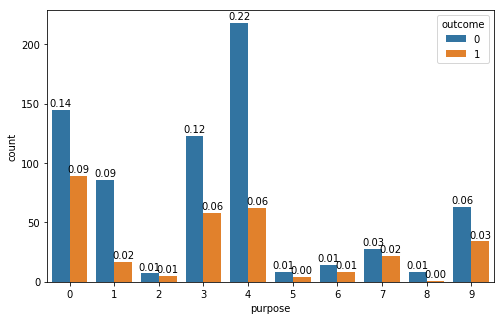

In [20]:
ax = sbn.countplot(x='purpose', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [21]:
# One Hot Encoding
mapping = {i:'A4'+str(i+1) for i in range(10)}
data.iloc[:, 3] = data.iloc[:, 3].map(mapping)
data = pd.concat([data, pd.get_dummies(data.iloc[:,3])], axis=1)

# 4 Credit Amount

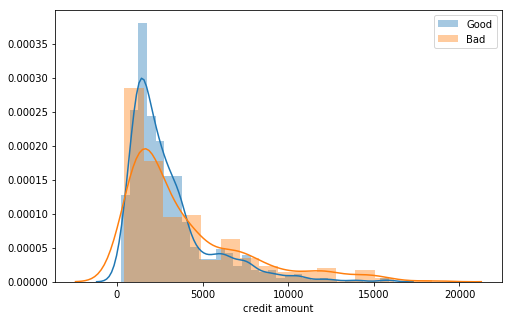

In [22]:
#ax = sbn.factorplot(x="checking account",y='credit amount', data=data, \
#               palette="hls", hue = "outcome" ,kind="violin" ,size=4, aspect=2, split=True)

ax = sbn.distplot(data[data.outcome==0].loc[:,'credit amount'] ,label='Good')
ax = sbn.distplot(data[data.outcome==1].loc[:,'credit amount'] ,label='Bad')
plt.legend()
plt.show()

In [23]:
data.iloc[:, 4] = minmax_scale(data.iloc[:, 4])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 5 Savings account/bonds 
A61 : ... < 100 DM 
A62 : 100 <= ... < 500 DM 
A63 : 500 <= ... < 1000 DM 
A64 : .. >= 1000 DM 
A65 : unknown/ no savings account 

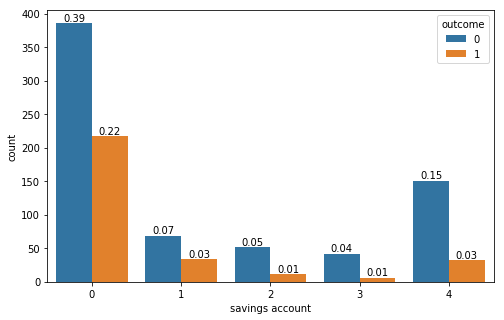

In [24]:
ax = sbn.countplot(x='savings account', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [25]:
# one hot encoding
mapping = {i:'A6'+str(i+1) for i in range(5)}
data.iloc[:, 5] = data.iloc[:, 5].map(mapping)
data = pd.concat([data, pd.get_dummies(data.iloc[:,5])], axis=1)

# 6 Present employment since 
A71 : unemployed 
A72 : ... < 1 year 
A73 : 1 <= ... < 4 years 
A74 : 4 <= ... < 7 years 
A75 : .. >= 7 years 

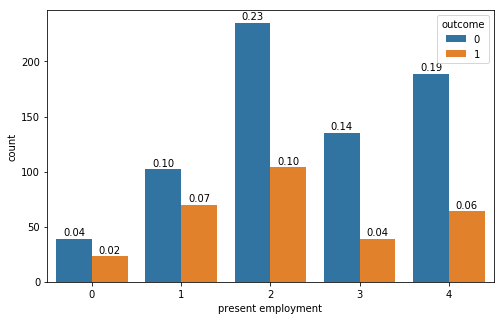

In [26]:
ax = sbn.countplot(x='present employment', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [27]:
data.iloc[:, 6] = minmax_scale(data.iloc[:, 6])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 7 installment rate

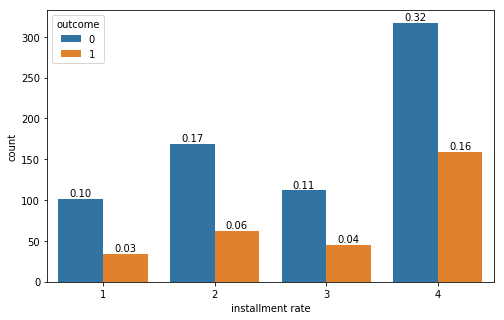

In [28]:
ax = sbn.countplot(x='installment rate', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [29]:
data.iloc[:, 7] = minmax_scale(data.iloc[:, 7])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 8 Personal status and sex 
A91 : male : divorced/separated 
A92 : female : divorced/separated/married 
A93 : male : single 
A94 : male : married/widowed 
A95 : female : single 

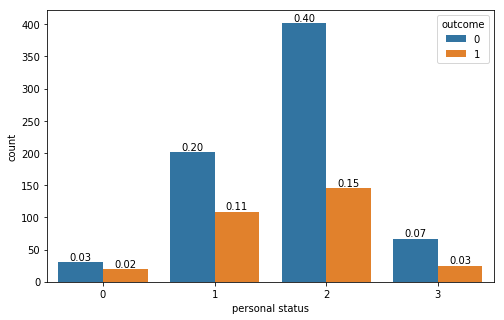

In [30]:
ax = sbn.countplot(x='personal status', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [31]:
# one hot encoding
mapping = {i:'A9'+str(i+1) for i in range(4)}
data.iloc[:, 8] = data.iloc[:, 8].map(mapping)
data = pd.concat([data, pd.get_dummies(data.iloc[:,8])], axis=1)

# 9 Other debtors / guarantors 
A101 : none 
A102 : co-applicant 
A103 : guarantor 

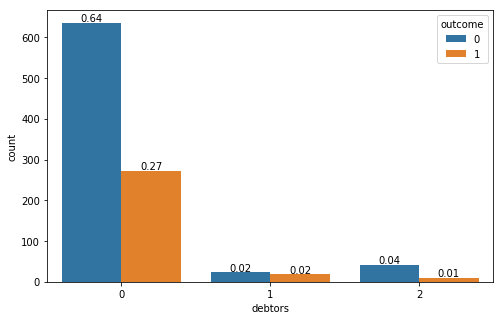

In [32]:
ax = sbn.countplot(x='debtors', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [33]:
#one hot encoding
mapping = {i:'A10'+str(i+1) for i in range(3)}
data.iloc[:, 9] = data.iloc[:, 9].map(mapping)
data = pd.concat([data, pd.get_dummies(data.iloc[:,9])], axis=1)

# 10 present residence

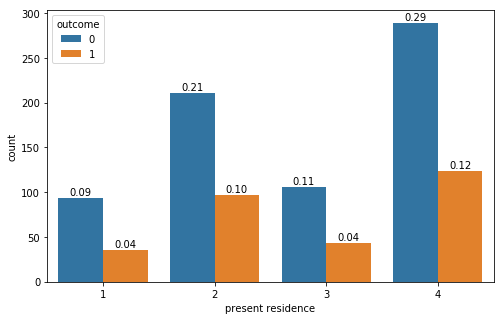

In [34]:
ax = sbn.countplot(x='present residence', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [35]:
data.iloc[:, 10] = minmax_scale(data.iloc[:, 10])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 11 Property 
A121 : real estate 
A122 : if not A121 : building society savings agreement/ life insurance 
A123 : if not A121/A122 : car or other, not in attribute 6 
A124 : unknown / no property

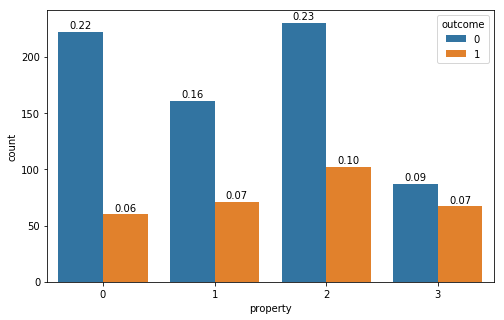

In [36]:
ax = sbn.countplot(x='property', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [37]:
data.iloc[:, 11] = minmax_scale(data.iloc[:, 11])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 12 Age

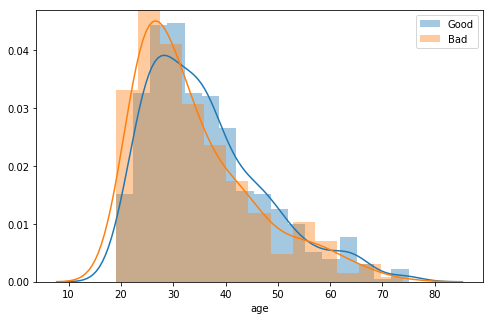

In [38]:
ax = sbn.distplot(data[data.outcome==0].loc[:,'age'] ,label='Good')
ax = sbn.distplot(data[data.outcome==1].loc[:,'age'] ,label='Bad')
plt.legend()
plt.show()

In [39]:
# one hot encoding
data.iloc[:, 12] = minmax_scale(data.iloc[:, 12])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 13 Other installment plans 
A141 : bank 
A142 : stores 
A143 : none 

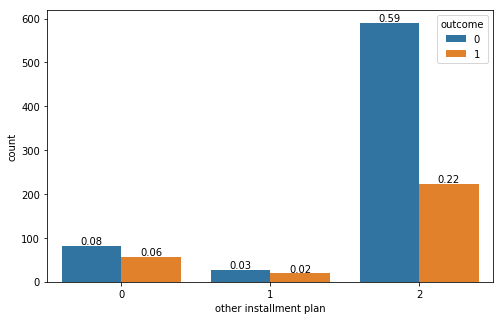

In [40]:
ax = sbn.countplot(x='other installment plan', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [41]:
data.iloc[:, 13] = minmax_scale(data.iloc[:, 13])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 14 Housing 
A151 : rent 
A152 : own 
A153 : for free 

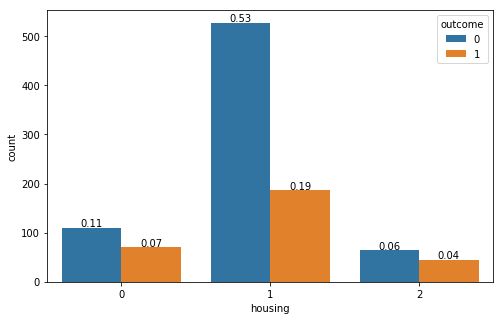

In [42]:
ax = sbn.countplot(x='housing', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [43]:
#re mapping
mapping = {0:1, 2:0, 1:3}
data.iloc[:, 14] = data.iloc[:, 14].map(mapping)
data.iloc[:, 14] = minmax_scale(data.iloc[:, 14])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 15 Number of existing credits at this bank 

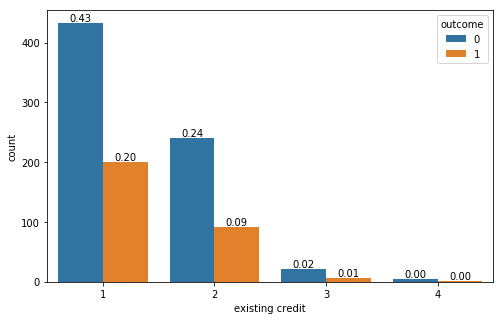

In [44]:
ax = sbn.countplot(x='existing credit', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [45]:
data.iloc[:, 15] = minmax_scale(data.iloc[:, 15])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 16 Job 
A171 : unemployed/ unskilled - non-resident 
A172 : unskilled - resident 
A173 : skilled employee / official 
A174 : management/ self-employed/ 

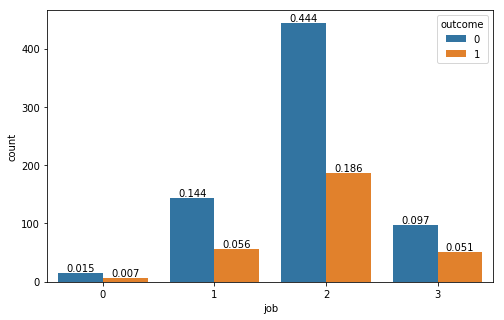

In [46]:
ax = sbn.countplot(x='job', hue='outcome', data=data)
total = float(data.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 

In [47]:
data.iloc[:, 16] = minmax_scale(data.iloc[:, 16])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 17 Number of People liable

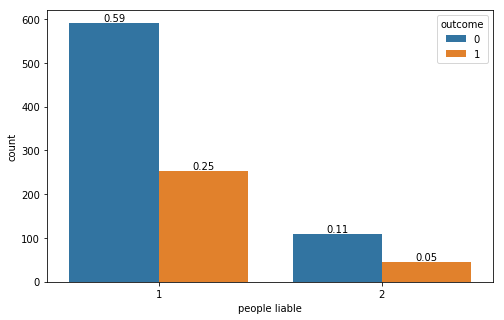

In [48]:
ax = sbn.countplot(x='people liable', hue='outcome', data=data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [49]:
data.iloc[:, 17] = minmax_scale(data.iloc[:, 17])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 18 Telephone 
A191 : none 
A192 : yes, registered under the customers name 

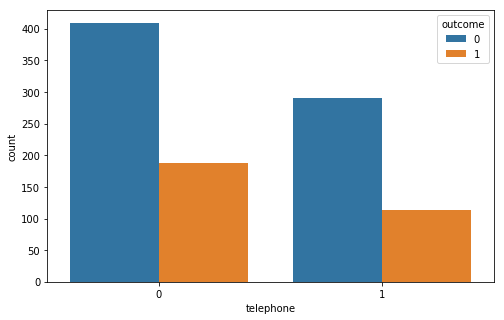

In [50]:
ax = sbn.countplot(x='telephone', hue='outcome', data=data)

In [51]:
data.iloc[:, 18] = minmax_scale(data.iloc[:, 18])

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


# 19 foreign worker 
A201 : yes 
A202 : no 

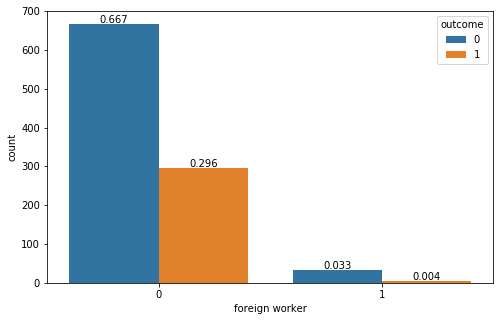

In [52]:
ax = sbn.countplot(x='foreign worker', hue='outcome', data=data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 

In [53]:
data_y = data['outcome']
d = ['purpose', 'savings account', 'personal status', 'debtors', 'outcome']
for col in d:
    del data[col]

# Make Prediciton after EDA and Preprocessing

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

train_X, test_X, train_y, test_y = train_test_split(data, data_y, test_size=0.25
                              , shuffle=True, random_state=42)

In [55]:
from sklearn import svm
model = svm.SVC(probability=True, C=6, gamma=0.02)
model.fit(train_X, train_y)
f1, tpr, fpr, precision, recall = optimize(model, train_X, train_y )

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [56]:
prediction = (model.predict_proba(test_X)[:,1] > 0.3).astype(int)
print(classification_report(test_y, prediction))
print('accuracy:', accuracy_score(test_y, prediction))

             precision    recall  f1-score   support

          0       0.88      0.74      0.80       178
          1       0.54      0.75      0.63        72

avg / total       0.78      0.74      0.75       250

accuracy: 0.744


In [57]:
confusion_matrix(test_y, prediction)

array([[132,  46],
       [ 18,  54]])

# Comparison between before and after data preprocessing

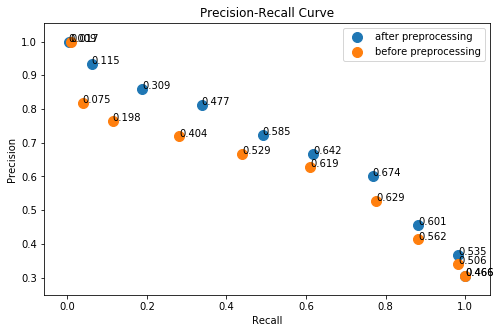

In [58]:
plt.scatter(recall ,precision, s=100, label='after preprocessing')
plt.scatter(recall_0 ,precision_0, s=100, label='before preprocessing')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
# Show F1 Score on each point
for i, txt in enumerate(f1):
    plt.annotate(txt, (recall[i],precision[i])) 
for i, txt in enumerate(f1_0):
    plt.annotate(txt, (recall_0[i],precision_0[i])) 